In [3]:
import pandas as pd
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [20]:

import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep

In [31]:
Tesla_df = pd.read_csv('TSLA.csv')
display(Tesla_df)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-19,41.742001,42.094002,40.155998,40.944000,40.944000,20193500
1,2016-01-20,39.880001,40.256001,38.250000,39.740002,39.740002,29193000
2,2016-01-21,40.310001,40.646000,39.004002,39.993999,39.993999,15831000
3,2016-01-22,40.959999,41.099998,39.806000,40.509998,40.509998,15620500
4,2016-01-25,40.012001,40.714001,39.175999,39.276001,39.276001,13493500
...,...,...,...,...,...,...,...
1254,2021-01-11,849.400024,854.429993,803.619995,811.190002,811.190002,59554100
1255,2021-01-12,831.000000,868.000000,827.340027,849.440002,849.440002,46270700
1256,2021-01-13,852.760010,860.469971,832.000000,854.409973,854.409973,33312500
1257,2021-01-14,843.390015,863.000000,838.750000,845.000000,845.000000,31266300


In [32]:
display(Tesla_df)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-19,41.742001,42.094002,40.155998,40.944000,40.944000,20193500
1,2016-01-20,39.880001,40.256001,38.250000,39.740002,39.740002,29193000
2,2016-01-21,40.310001,40.646000,39.004002,39.993999,39.993999,15831000
3,2016-01-22,40.959999,41.099998,39.806000,40.509998,40.509998,15620500
4,2016-01-25,40.012001,40.714001,39.175999,39.276001,39.276001,13493500
...,...,...,...,...,...,...,...
1254,2021-01-11,849.400024,854.429993,803.619995,811.190002,811.190002,59554100
1255,2021-01-12,831.000000,868.000000,827.340027,849.440002,849.440002,46270700
1256,2021-01-13,852.760010,860.469971,832.000000,854.409973,854.409973,33312500
1257,2021-01-14,843.390015,863.000000,838.750000,845.000000,845.000000,31266300


In [5]:
Tesla_prices = Tesla_df.Close.values.astype('float32')

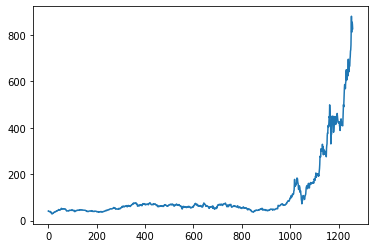

In [6]:
plt.plot(Tesla_prices)
plt.show()

Train/test model

In [34]:
#creating dataframe
data = Tesla_df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(Tesla_df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]


In [45]:
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

In [46]:
dataset = new_data.values

In [47]:
print(len(dataset))

1259


In [48]:
print(1259*.80)

1007.2


In [49]:
train = dataset[0:1007,:]
valid = dataset[1007:,:]

In [50]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [51]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

We Train future predictions based on past 60 days, helps with the short memory in ltsm model

In [52]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [53]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)


947/947 - 9s - loss: 4.4047e-05


In [54]:

inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [55]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

In [56]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [57]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

29.158191641367296

<ipython-input-59-a875403c9bbf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


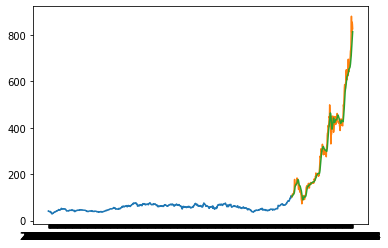

In [59]:
train = new_data[:1007]
valid = new_data[1007:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.show()

In [60]:
print(closing_price)

[[103.70684 ]
 [104.409035]
 [105.68061 ]
 [107.690445]
 [109.88409 ]
 [111.67415 ]
 [112.82746 ]
 [113.74192 ]
 [114.79924 ]
 [117.439095]
 [120.81008 ]
 [127.67934 ]
 [138.38329 ]
 [145.3939  ]
 [149.94568 ]
 [152.57562 ]
 [154.49252 ]
 [155.86205 ]
 [156.56696 ]
 [157.85158 ]
 [159.15369 ]
 [161.91116 ]
 [166.68373 ]
 [171.35489 ]
 [175.3939  ]
 [176.70444 ]
 [175.50499 ]
 [172.59877 ]
 [166.45792 ]
 [159.19557 ]
 [154.44069 ]
 [151.6909  ]
 [150.48152 ]
 [149.5615  ]
 [148.35193 ]
 [144.53473 ]
 [140.93521 ]
 [137.63547 ]
 [132.91507 ]
 [127.72793 ]
 [120.21229 ]
 [112.11392 ]
 [102.92294 ]
 [ 96.24546 ]
 [ 91.775276]
 [ 89.24567 ]
 [ 90.008194]
 [ 93.31157 ]
 [ 97.171875]
 [100.40663 ]
 [102.52671 ]
 [104.36552 ]
 [104.62006 ]
 [103.25663 ]
 [101.92462 ]
 [101.76759 ]
 [103.028435]
 [104.93269 ]
 [107.56618 ]
 [112.35713 ]
 [119.228714]
 [126.78322 ]
 [134.07837 ]
 [140.47502 ]
 [145.31648 ]
 [147.0361  ]
 [148.15823 ]
 [148.07642 ]
 [147.92291 ]
 [149.7875  ]
 [151.6225  ]
 [154.